In [2]:
import astropy
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from matplotlib.colors import LogNorm
from astropy import units as u
import galpy
from galpy.orbit import Orbit
from astropy.coordinates import SkyCoord
from galpy.potential import MWPotential2014
from astropy.coordinates import SkyCoord, Galactocentric, CartesianDifferential
from matplotlib.colors import Normalize
from matplotlib.patches import Ellipse, Circle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import pygmmis

In [3]:
vphi_data = 'v_dataset.fits'

with fits.open(vphi_data) as hdul:
    data = hdul[1].data  
    
    df_v = pd.DataFrame({col.name: data[col.name].byteswap().newbyteorder() if data[col.name].dtype.byteorder == '>' else data[col.name]
                       for col in hdul[1].columns})

In [5]:
pd.set_option('display.max_columns', None)

df_v.head()

,source_id,l,b,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ruwe,radial_velocity,radial_velocity_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,catwise_w1,catwise_w2,mh_xgboost,teff_xgboost,logg_xgboost,in_training_sample,col1,col2,Source,RA_ICRS,DE_ICRS,rgeo,b_rgeo_x,B_rgeo_xa,rpgeo,b_rpgeo_x,B_rpgeo_xa,Flag,angDist,fpu,E(B-V),distance_kpc,R,Z,R_gal,phi_gal,Z_gal,v_phi,v_phi_error,v_R,v_Z,v_R_error,v_Z_error
0,15741055975040,176.739184,-48.572035,45.136038,0.335043,1.439792,0.018947,-0.711280,0.017718,-1.412098,0.016528,1.036041,-0.738894,0.316921,10.254021,10.750235,9.595748,8.152,8.198,-0.144,5065.8,2.993,True,45.136038,0.335043,15741055975040,45.136038,0.335043,695.683899,683.627625,707.396423,696.278320,688.270874,707.143982,10033,0.0,0.013160,0.104689,696.278320,8.582006,-0.522061,470.485258,0.055731,-520.632142,243.095762,3.438279,-14.428048,4.529900,0.079977,0.326857
1,66627828480768,176.483565,-48.171322,45.305053,0.736093,0.534038,0.020692,3.309832,0.022959,1.594356,0.022822,1.349013,41.607450,1.323430,10.508830,11.150953,9.741709,7.891,7.964,-0.401,4499.0,1.916,False,45.305053,0.736093,66627828480768,45.305053,0.736093,1884.275020,1821.247560,1947.302730,1883.143550,1807.318600,1944.665770,10033,0.0,0.038747,0.093026,1883.143550,9.375831,-1.403210,1268.325930,0.060773,-1399.358389,237.364263,8.774407,42.346437,-2.860027,0.288987,1.354615
2,82467667849472,176.209301,-48.607026,44.866246,0.561503,2.209985,0.016049,-4.869755,0.015797,-12.678339,0.013950,1.018742,-32.461674,0.205614,10.651456,11.169626,9.980610,8.496,8.558,0.114,4938.3,3.203,True,44.866246,0.561503,82467667849472,44.866246,0.561503,452.636078,448.701294,456.615540,452.602692,449.257355,455.432892,10033,0.0,0.007262,0.086075,452.602692,8.420638,-0.339539,308.483632,0.064184,-338.602406,230.329127,1.781392,-51.045366,13.944756,0.045217,0.210527
3,101193725229056,175.755174,-48.727781,44.569524,0.689953,0.528788,0.024241,3.539184,0.027864,-1.599436,0.021891,1.176748,91.295900,4.830661,14.332739,14.816101,13.685076,12.220,12.275,-0.478,4980.2,3.319,False,44.569524,0.689953,101193725229056,44.569524,0.689953,1908.478270,1815.024170,2014.483890,1868.603880,1800.940800,1949.831300,10033,0.0,0.045842,0.078062,1868.603880,9.351665,-1.404413,1245.041147,0.073347,-1400.635394,217.472712,8.804845,62.829005,-53.068842,0.313884,4.840848
4,130399502833792,175.789759,-48.328584,44.868872,0.955080,0.847929,0.017479,3.382907,0.017619,-0.291235,0.015982,1.087555,1.959265,0.328298,11.215295,11.810178,10.481738,8.728,8.815,-0.159,4643.6,2.398,True,44.868872,0.955080,130399502833792,44.868872,0.955080,1178.407470,1155.319820,1203.711180,1177.687260,1154.219600,1201.322750,10033,0.0,0.020614,0.077163,1177.687260,8.903067,-0.879697,793.842786,0.072479,-877.288236,231.337541,4.733542,1.866465,13.969564,0.132801,0.354141


In [21]:
df_v = df_v[np.abs(df_v['Z']) < 2.5]
df_v = df_v.dropna(subset=["v_R", "v_phi", "v_R_error", "v_phi_error", "v_Z", "v_Z_error"])

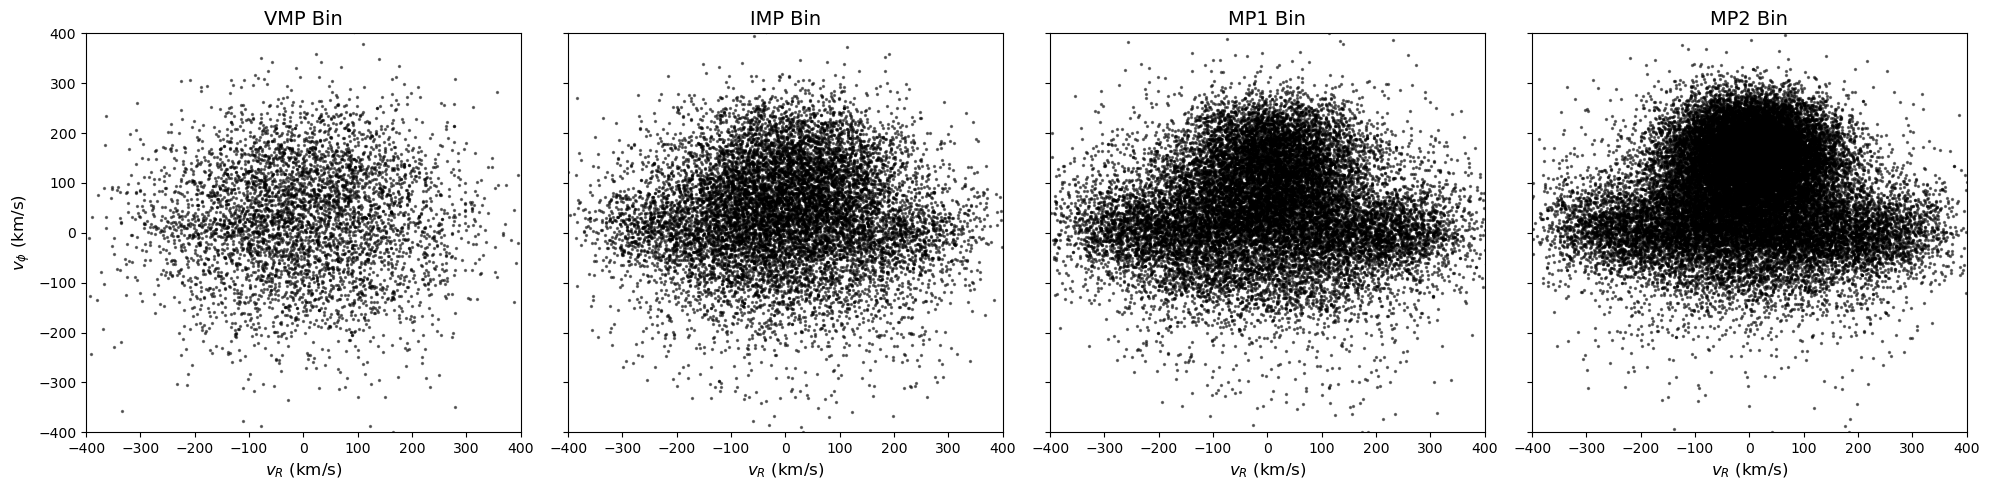

In [22]:
# Metallicity bins for GMM
metallicity_bins = {
    "VMP": (-3.0, -2.0),  # Very metal-poor
    "IMP": (-2.0, -1.6),  # Intermediate metal-poor
    "MP1": (-1.6, -1.3),  # Metal-poor 1
    "MP2": (-1.3, -1.0)   # Metal-poor 2
}

# Create a figure with subplots for each metallicity bin
fig, axes = plt.subplots(1, len(metallicity_bins), figsize=(20, 5), sharex=True, sharey=True)

for idx, (bin_name, (mh_min, mh_max)) in enumerate(metallicity_bins.items()):
    df_bin = df_v.query(f"{mh_min} < mh_xgboost < {mh_max}")

    if df_bin.empty:
        continue

    # Scatter plot of v_phi vs v_R
    ax = axes[idx]
    ax.scatter(df_bin["v_R"], df_bin["v_phi"], s=2, alpha=0.5, color="black")

    # Titles and labels
    ax.set_title(f"{bin_name} Bin", fontsize=14)
    ax.set_xlabel(r"$v_R$ (km/s)", fontsize=12)
    if idx == 0:
        ax.set_ylabel(r"$v_\phi$ (km/s)", fontsize=12)

# Set x and y limits for uniform scale
plt.xlim(-400, 400)
plt.ylim(-400, 400)

plt.tight_layout()
plt.show()


## Function for getting BIC scores

In [24]:
import numpy as np
import pygmmis
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define function to compute BIC
def compute_bic(N, velocities, covariances, n_repeats=50, pbar=None):
    """
    Fit a GMM with N components multiple times and return min, median, max BIC.
    Updates the progress bar.
    """
    logL_values = np.full(n_repeats, -np.inf)  # Initialize with -inf to handle failures

    # Check if sample size is large enough
    if len(velocities) < N:
        return N, (np.inf, np.inf, np.inf)  # Return high BIC if not enough data

    for i in range(n_repeats):
        try:
            # Initialise GMM with random means
            gmm = pygmmis.GMM(K=N, D=3)
            gmm.means = np.random.normal(np.mean(velocities, axis=0), np.std(velocities, axis=0), (N, 3))

            # Fit model
            logL, _ = pygmmis.fit(gmm, velocities, covariances)

            # Store log-likelihood
            logL_values[i] = logL

        except Exception as e:
            print(f"Warning: GMM fit failed for N={N}, iteration {i} - {e}")

        # Update progress bar
        if pbar:
            pbar.update(1)

    # Prevent NaN or -inf values in log-likelihood
    logL_values = np.nan_to_num(logL_values, nan=-np.inf, neginf=-np.inf)

    # Compute BIC: BIC = k log(n) - 2 logL
    k_params = (1 + 3 + 6) * N - 1  # Total number of parameters
    n_samples = len(velocities)
    bic_values = k_params * np.log(n_samples) - 2 * logL_values

    return N, (bic_values.min(), np.median(bic_values), bic_values.max())


### VMP Bin

In [25]:
import numpy as np
import pygmmis
import matplotlib.pyplot as plt
from tqdm import tqdm

# Select the first metallicity bin
first_bin_name = next(iter(metallicity_bins.keys()))  # Get first bin name (e.g., "VMP")
mh_min, mh_max = metallicity_bins[first_bin_name]
print(f"\nProcessing {first_bin_name} bin...")

# Filter dataset for the first metallicity bin
df_bin = df_v.query(f"{mh_min} < mh_xgboost < {mh_max}")

if df_bin.empty:
    print(f"Skipping {first_bin_name}: No data available.")
else:
    # Extract velocity values
    velocities = df_bin[["v_R", "v_phi", "v_Z"]].to_numpy()

    # Assign individual diagonal covariance matrices for each star
    covariances = np.array([
        np.diag([
            df_bin["v_R_error"].iloc[i] ** 2,   # Squared uncertainty in v_R
            df_bin["v_phi_error"].iloc[i] ** 2, # Squared uncertainty in v_phi
            df_bin["v_Z_error"].iloc[i] ** 2    # Squared uncertainty in v_Z
        ])
        for i in range(len(df_bin))
    ])

    # Define range of Gaussian components to test (1 to 8)
    N_components_list = np.arange(1, 9)

    # Store BIC results for the first bin only
    bic_results_first_bin = {}

    # Create a progress bar
    with tqdm(total=len(N_components_list) * 50, desc=f"GMM BIC for {first_bin_name}") as pbar:
        for N in N_components_list:
            N, bic_values = compute_bic(N, velocities, covariances, pbar=pbar)
            bic_results_first_bin[N] = bic_values  # Store BIC results

print("\n✅ GMM fitting complete for first metallicity bin!")



Processing VMP bin...


GMM BIC for VMP: 100%|██████████| 400/400 [15:24<00:00,  2.31s/it]


✅ GMM fitting complete for first metallicity bin!


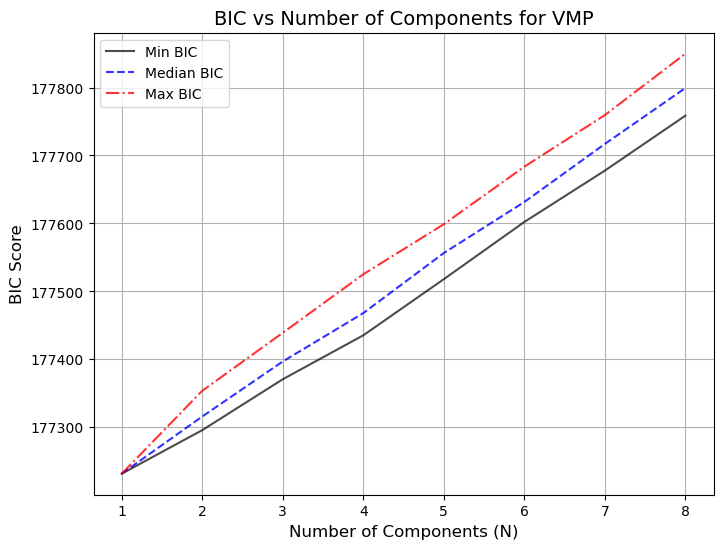

In [28]:
# Extract BIC values for each N
N_values = list(bic_results_first_bin.keys())  # Number of components
bic_min = [bic_results_first_bin[N][0] for N in N_values]  # Min BIC
bic_median = [bic_results_first_bin[N][1] for N in N_values]  # Median BIC
bic_max = [bic_results_first_bin[N][2] for N in N_values]  # Max BIC

# Plot BIC values
plt.figure(figsize=(8, 6))
plt.plot(N_values, bic_min, 'k-', label="Min BIC", alpha=0.7)
plt.plot(N_values, bic_median, 'b--', label="Median BIC", alpha=0.8)
plt.plot(N_values, bic_max, 'r-.', label="Max BIC", alpha=0.8)

# Labels and title
plt.xlabel("Number of Components (N)", fontsize=12)
plt.ylabel("BIC Score", fontsize=12)
plt.title(f"BIC vs Number of Components for {first_bin_name}", fontsize=14)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()



✅ Processing VMP bin...
✅ Optimal number of Gaussians: 1


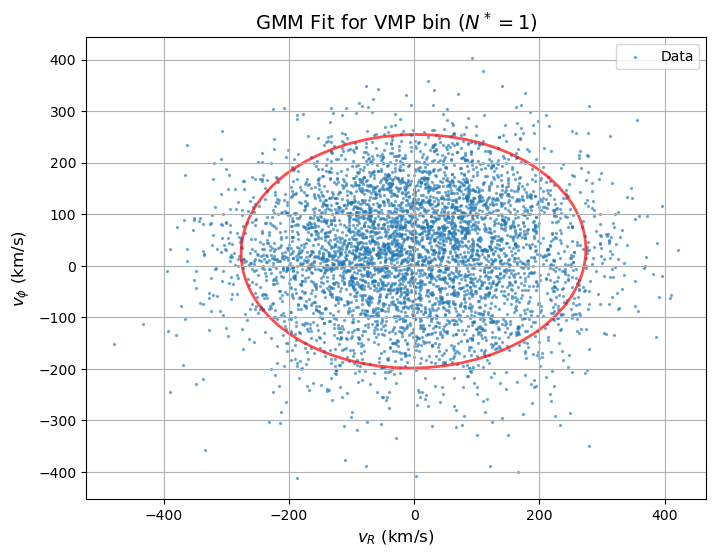

In [34]:
import numpy as np
import pygmmis
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# Select the first metallicity bin
first_bin_name = next(iter(metallicity_bins.keys()))  # Get first bin name (e.g., "VMP")
mh_min, mh_max = metallicity_bins[first_bin_name]
print(f"\n✅ Processing {first_bin_name} bin...")

# Filter dataset for the first metallicity bin
df_bin = df_v.query(f"{mh_min} < mh_xgboost < {mh_max}")

if df_bin.empty:
    print(f"❌ Skipping {first_bin_name}: No data available.")
else:
    # Extract velocity values for first bin
    velocities = df_bin[["v_R", "v_phi", "v_Z"]].to_numpy()

    # Assign diagonal covariance matrix using per-star errors
    covariances = np.array([
        np.diag([
            df_bin["v_R_error"].iloc[i] ** 2,
            df_bin["v_phi_error"].iloc[i] ** 2,
            df_bin["v_Z_error"].iloc[i] ** 2
        ])
        for i in range(len(df_bin))
    ])

    # Ensure correct number of velocities
    assert len(velocities) == len(df_bin), "Mismatch: velocities should come from the first bin only!"

    # Find the optimal number of Gaussians (N*) based on min BIC
    optimal_N = min(bic_results_first_bin, key=lambda N: bic_results_first_bin[N][0])  # Min BIC
    print(f"✅ Optimal number of Gaussians: {optimal_N}")

    # Fit the best GMM model
    gmm = pygmmis.GMM(K=optimal_N, D=3)  # 3D GMM (v_R, v_phi, v_Z)
    logL, responsibilities = pygmmis.fit(gmm, velocities, covariances)  # Fit model

    # Extract means and covariances (Only take v_R, v_phi)
    means = np.array([gmm.mean[i][:2] for i in range(optimal_N)])  # (v_R, v_phi)
    covariances = np.array([gmm.covar[i][:2, :2] for i in range(optimal_N)])  # Covariances (v_R, v_phi)

    # Plot the velocity distribution
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(df_bin["v_R"], df_bin["v_phi"], s=2, alpha=0.5, label="Data")  # Scatter plot of data

    # Add ellipses for GMM components
    for i in range(optimal_N):
        mean = means[i]
        cov = covariances[i]

        # Compute eigenvalues & eigenvectors of covariance matrix
        eigenvalues, eigenvectors = np.linalg.eigh(cov)

        # Compute angle of rotation from eigenvector
        angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

        # Width & height of the ellipse (2-sigma)
        width, height = 2 * np.sqrt(eigenvalues) * 2  # 2-sigma confidence interval

        # Add ellipse to plot
        ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, 
                          edgecolor='red', facecolor='none', linewidth=2, alpha=0.7)
        ax.add_patch(ellipse)

    # Labels and title
    ax.set_xlabel("$v_R$ (km/s)", fontsize=12)
    ax.set_ylabel("$v_\\phi$ (km/s)", fontsize=12)
    ax.set_title(f"GMM Fit for {first_bin_name} bin ($N^*={optimal_N}$)", fontsize=14)
    ax.legend()
    ax.grid(True)

    # Show plot
    plt.show()


# MP2 bin

In [35]:
# Select the last metallicity bin
bin_names = list(metallicity_bins.keys())  # Get all bin names
last_bin_name = bin_names[-1]  # Get last bin name (e.g., "MP2")
mh_min, mh_max = metallicity_bins[last_bin_name]
print(f"\nProcessing {last_bin_name} bin...")

# Filter dataset for the last metallicity bin
df_bin = df_v.query(f"{mh_min} < mh_xgboost < {mh_max}")

if df_bin.empty:
    print(f"Skipping {last_bin_name}: No data available.")
else:
    # Extract velocity values
    velocities = df_bin[["v_R", "v_phi", "v_Z"]].to_numpy()

    # Assign individual diagonal covariance matrices for each star
    covariances = np.array([
        np.diag([
            df_bin["v_R_error"].iloc[i] ** 2,   # Squared uncertainty in v_R
            df_bin["v_phi_error"].iloc[i] ** 2, # Squared uncertainty in v_phi
            df_bin["v_Z_error"].iloc[i] ** 2    # Squared uncertainty in v_Z
        ])
        for i in range(len(df_bin))
    ])

    # Define range of Gaussian components to test (1 to 8)
    N_components_list = np.arange(1, 9)

    # Store BIC results for the last bin only
    bic_results_last_bin = {}

    # Create a progress bar
    with tqdm(total=len(N_components_list) * 50, desc=f"GMM BIC for {last_bin_name}") as pbar:
        for N in N_components_list:
            N, bic_values = compute_bic(N, velocities, covariances, pbar=pbar)
            bic_results_last_bin[N] = bic_values  # Store BIC results

print("\n✅ GMM fitting complete for last metallicity bin!")



Processing MP2 bin...


GMM BIC for MP2: 100%|██████████| 400/400 [28:17<00:00,  4.24s/it]  


✅ GMM fitting complete for last metallicity bin!


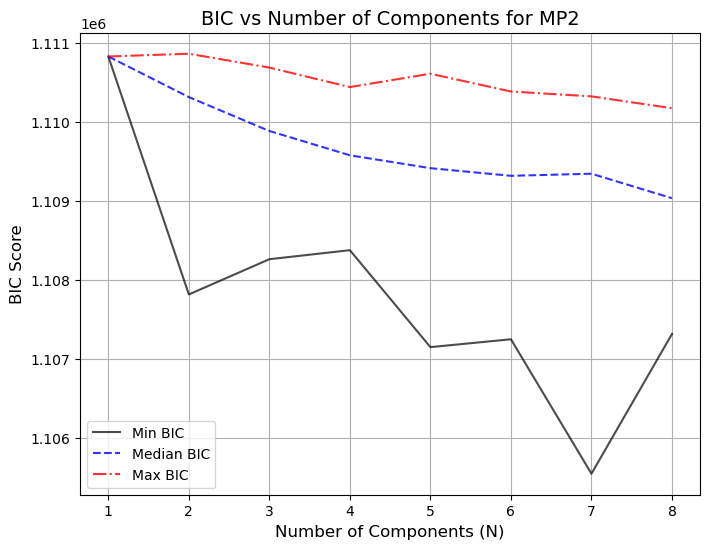

In [36]:
# Extract BIC values for MP2 bin
N_values = list(bic_results_last_bin.keys())  # Number of components
bic_min = [bic_results_last_bin[N][0] for N in N_values]  # Min BIC
bic_median = [bic_results_last_bin[N][1] for N in N_values]  # Median BIC
bic_max = [bic_results_last_bin[N][2] for N in N_values]  # Max BIC

# Plot BIC values
plt.figure(figsize=(8, 6))
plt.plot(N_values, bic_min, 'k-', label="Min BIC", alpha=0.7)
plt.plot(N_values, bic_median, 'b--', label="Median BIC", alpha=0.8)
plt.plot(N_values, bic_max, 'r-.', label="Max BIC", alpha=0.8)

# Labels and title
plt.xlabel("Number of Components (N)", fontsize=12)
plt.ylabel("BIC Score", fontsize=12)
plt.title(f"BIC vs Number of Components for {last_bin_name}", fontsize=14)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


Optimal number of Gaussians for MP2: 7


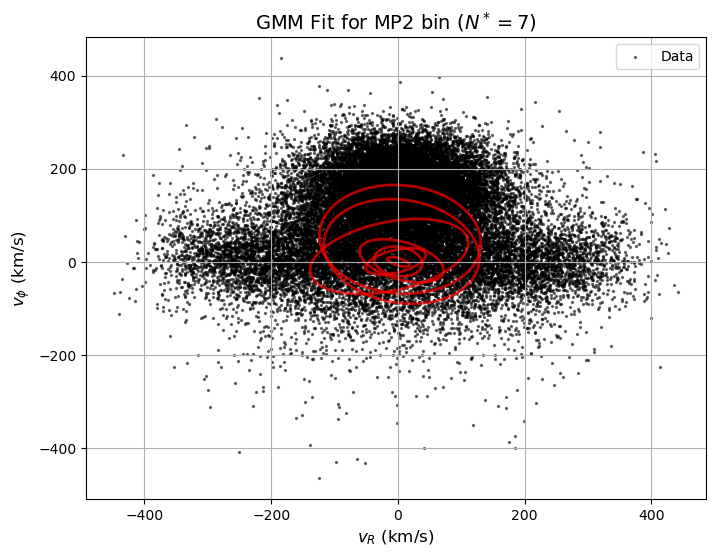

In [37]:
import numpy as np
import pygmmis
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# Find the optimal number of Gaussians (N*) based on min BIC
optimal_N = min(bic_results_last_bin, key=lambda N: bic_results_last_bin[N][0])  # Find N with min BIC
print(f"Optimal number of Gaussians for {last_bin_name}: {optimal_N}")

# Fit the best GMM model
gmm = pygmmis.GMM(K=optimal_N, D=3)  # 3D GMM (v_R, v_phi, v_Z)
logL, responsibilities = pygmmis.fit(gmm, velocities, covariances)  # Fit model

# Extract means and covariances for v_R, v_phi
means = np.array([gmm.amp[i] * gmm.mean[i][:2] for i in range(optimal_N)])  # Only (v_R, v_phi)
covariances = np.array([gmm.amp[i] * gmm.covar[i][:2, :2] for i in range(optimal_N)])  # (v_R, v_phi) covariances

# Plot the velocity distribution
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(df_bin["v_R"], df_bin["v_phi"], s=2, alpha=0.5, label="Data", color="black")  # Scatter plot of data

# Add ellipses for GMM components
for i in range(optimal_N):
    mean = means[i]
    cov = covariances[i]
    
    # Compute eigenvalues & eigenvectors of covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    
    # Compute angle of rotation from eigenvector
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    
    # Width & height of the ellipse (2-sigma)
    width, height = 2 * np.sqrt(eigenvalues) * 2  # 2-sigma confidence interval

    # Add ellipse to plot
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, 
                      edgecolor='red', facecolor='none', linewidth=2, alpha=0.7)
    ax.add_patch(ellipse)

# Labels and title
ax.set_xlabel("$v_R$ (km/s)", fontsize=12)
ax.set_ylabel("$v_\\phi$ (km/s)", fontsize=12)
ax.set_title(f"GMM Fit for {last_bin_name} bin ($N^*={optimal_N}$)", fontsize=14)
ax.legend()
ax.grid(True)

# Show plot
plt.show()
